#### Imports

In this little part we'll import and review our data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# from tqdm.auto import tqdm
# from scipy.sparse import coo_matrix, hstack
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('NLP challenge - Sheet1.csv')
df.columns = ['ID', 'Text', 'Answer']
display(df.head(6))

### Tweets Labeling
rows_unique = df.Text.unique()
dict_text_label = {rows_unique[i]: i for i in range(len(rows_unique))}
df.Text = df.Text.apply(lambda x: dict_text_label[x])
display(df.head(6))

,ID,Text,Answer
0,A1MG8KNVSVZ365,@cz_binance Thanks for being upfront about thi...,True
1,A3OCJJMRKAIJZA,@cz_binance Thanks for being upfront about thi...,True
2,AQIP3DSYXEXX5,@cz_binance Thanks for being upfront about thi...,True
3,A1MG8KNVSVZ365,@cz_binance The speed with which Binance has r...,False
4,A3MV3PT4TOO69P,@cz_binance The speed with which Binance has r...,True
5,AQIP3DSYXEXX5,@cz_binance The speed with which Binance has r...,True


,ID,Text,Answer
0,A1MG8KNVSVZ365,0,True
1,A3OCJJMRKAIJZA,0,True
2,AQIP3DSYXEXX5,0,True
3,A1MG8KNVSVZ365,1,False
4,A3MV3PT4TOO69P,1,True
5,AQIP3DSYXEXX5,1,True


In [3]:
display(df.ID.value_counts()[:5])
display(df.ID.value_counts()[-5:])

A3MV3PT4TOO69P    5126
A3OCJJMRKAIJZA    5001
A3BISMR4GI02ZG    3589
A1MG8KNVSVZ365    3561
AQIP3DSYXEXX5     3469
Name: ID, dtype: int64

A2JP9IKRHNLRPI    3
A2GO2OXS4VM1PR    2
AKSJ3C5O3V9RB     2
A2QTL039A5VV3I    1
A27W025UEXS1G0    1
Name: ID, dtype: int64

As we can see the data is highly unbalanced. For each tweet we have only three observations from random taken IDs. This research will be considered in two ways - with "naive approach" and "a little less naive approach". I guess it's a fair names сonsidering a size of data and number of samples in each group.

However we should denote the object beforehand - "Identify bots amongst annotators". So our output is obviously - make some distinction/clustering/classification/outlier_detection on IDs and identify that "bot cluster".

#### *Naive approach*
First idea that visits my mind is very obvious (and naive). We have some bots in our data makers - what if we can identify bots by their similar specific behavior for example:
* by answer distributions
* by rule of minority

But in that case our lack of additional information take place:
* we don't know how similar answer distributions for bot IDs;
* we don't know even precisely share of bot IDs;
* we don't know if they have any communicative source to answer in a similar manner on the same questions or not.

So in that case both answer distribution analysis and rule of minority analysis became irrelevant. For example we do have 80% bot IDs and 20% real IDs. That means that in the case of trying to identify outlier behavior among grouped by tweets data we will discover that our minority group is outlier in any way. Same true for distribution analysis - grouping by some anwer distribution aspects turned out to be too unreliable criteria in that case.

However there turn out to be a little interesting notation:

There criterias
* we don't know how similar answer distributions for bot IDs;
* we don't know if they have any communicative source to answer in a similar manner on the same questions or not.
turned out to be self exclusive for very large data (what obviously doesn't really apply for such a little dataframe).
Let's prove that from contrary. Assume that we have many bots with an answer database and that their distributions are distinct.
Due to the central limit theorem (binomial distribution version) samples will tend to have the same distribution as the general distribution.
So having these two properties of bot IDs would be strictly impossible for a large dataset (and however still possible for our data yet sometimes we don't have better options).

#### *A little less naive approach*
Main idea for that approach is taken from the previous abstract. Bots could have any random distributions with any random parameters they want BUT they still remain random.
However If we consider real IDs to be rational in answers - that tends to be our methodology's starting point. That means that our real IDs should have higher intercrossing indicators than bot IDs.
Yet we still have a highly unbalancing problem and will try to manage it with bayes estimation.

In [4]:
general_mean = df.Answer.mean()
print(f'General Mean: {general_mean}')

General Mean: 0.5432353021940303


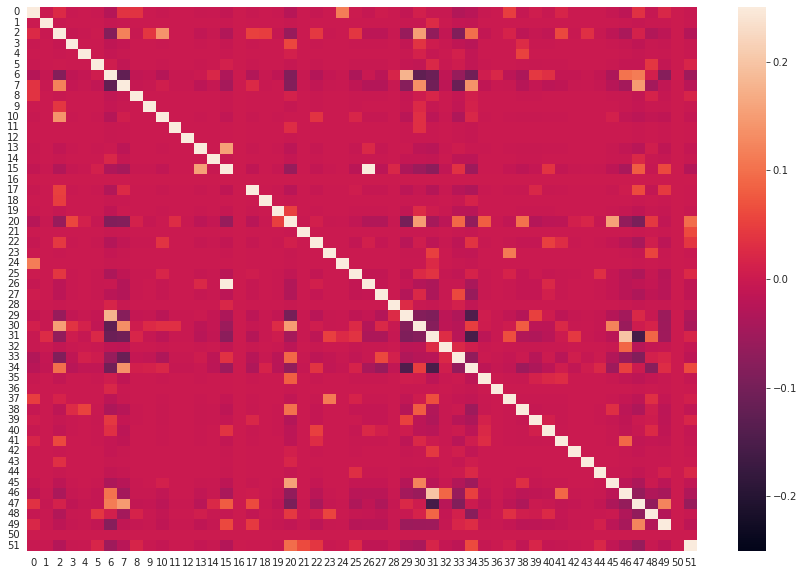

In [5]:
df.Answer = df.Answer.astype('int8')
df_pivot = pd.pivot_table(data=df, index='ID', columns='Text', values='Answer',
                          fill_value=0
                         )
corr = np.corrcoef(df_pivot)
corr[np.isnan(corr)] = 0

with sns.axes_style("white"):

    f, ax = plt.subplots(figsize=(15, 10))

    ax = sns.heatmap(data=corr, vmax=.25, vmin=-.25)

Text(0.5, 1.0, 'mean correlation distribution')

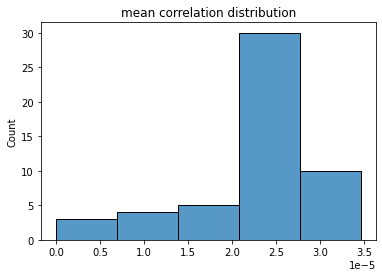

In [6]:
sns.histplot(corr.sum(0)/df.shape[0], bins=5)
plt.title('mean correlation distribution')

As we can see heatmap with correlation values as inputs shows us visible irregularities. And eve mean correlation distribution graph shows us specific bin. However we can't relate on this graphs wholly because we haven't deal with unbalancing problem. As we've seen earlier some IDs have many thousand samples, others - only units. In that case there is a high probability of random correlations. Moreover that values would have the same "weight" as values based on way more samples. We will minimize that distortion through creating a "similarity matrix". Rows and columns of that matrix would be our unique IDs. And in the values of that matrix we will insert accuracy between all intercrossing samples scaled by bayes estimation technique.

In [7]:
df.Answer = df.Answer.astype('int8')
df.Answer.replace(to_replace=0, value=-1, inplace=True) # replacing 0 with -1 for creating more contrast images
df_pivot = pd.pivot_table(data=df, index='ID', columns='Text', values='Answer', # recreating pivot table without fillna - for easy catching intersections
                         )

In [8]:
prior = df_pivot.mean().median() # estimating prior value for bayes estimation
print(f'Prior Value: {prior}')

def bayes_estimation(data, additional_examples=10, prior=0.5):
    data_len = data.shape[1]
    data_mean = data.mean().mean()
    first_part = data_len/(data_len+additional_examples)*data_mean
    second_part = additional_examples/(data_len+additional_examples)*prior
    return first_part+second_part


# creating structure for similarity matrix
df_rows_len = df_pivot.shape[0]
df_rows_names = df_pivot.index

sim_matrix = pd.DataFrame(np.zeros(shape=(df_rows_len, df_rows_len)),
                          index=df_rows_names, columns=df_rows_names)

#inputing matrix
for i in sim_matrix.index:
    for j in sim_matrix.columns:
        if i==j:
            sim_matrix.loc[i, j] = 1
        else:
            values = df_pivot.loc[[i, j]].dropna(axis=1)
            if values.empty:
                sim_matrix.loc[i, j] = np.nan
            else:
                sim_matrix.loc[i, j] = bayes_estimation(values.values, additional_examples=20, prior=prior)

Prior Value: 0.3333333333333333


<AxesSubplot:xlabel='ID', ylabel='ID'>

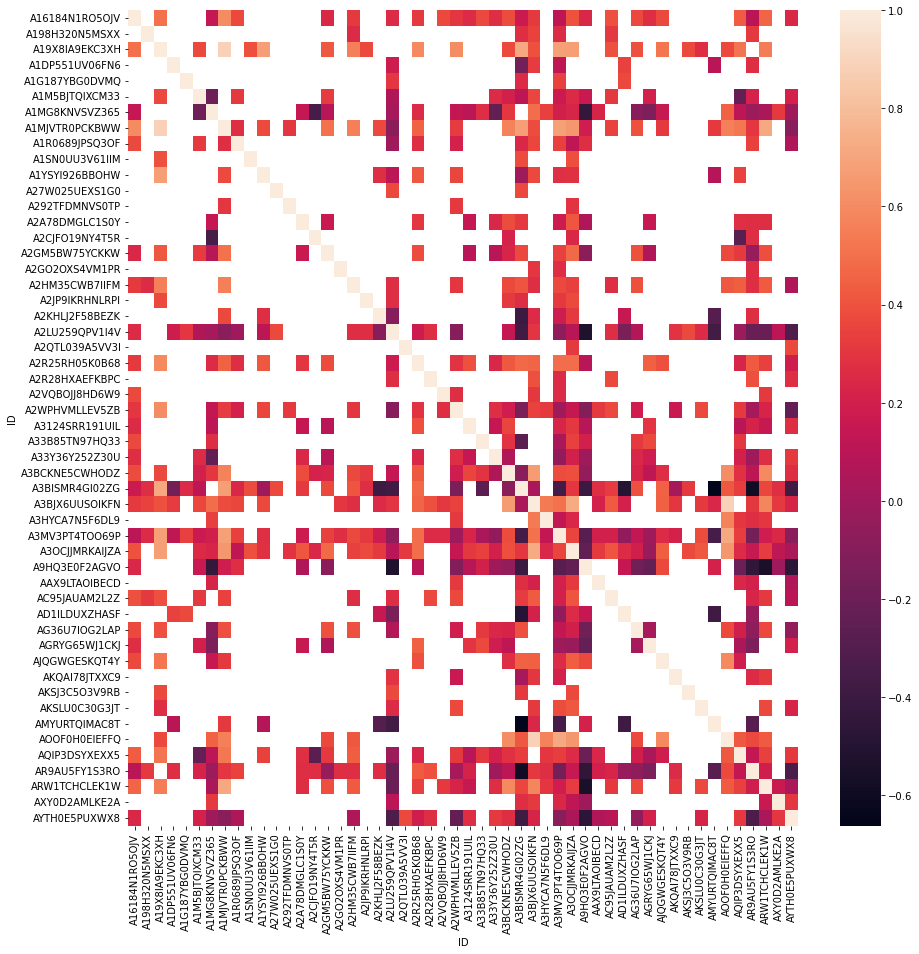

In [9]:
# similarity matrix heatmap
plt.figure(figsize=(15,15))
sns.heatmap(sim_matrix)

Now let's take a look at a similarity matrix heatmap. White places tell us that there were not any crossing between IDs. Other points show us mean accuracy between all intercrossings. So now we can try to find any structure there or just somehow rank them all and find outliers. Looking ahead I want to say that just ranking IDs by, for example, mean values won't work very well. And even statistical outliers finding methods like z-score and IQR won't be very informative.
That's why we'll explore the structure of our similarity matrix. Without any intriguing news... let me present you... BiClustering method.

In [10]:
from sklearn.cluster import SpectralBiclustering

model = SpectralBiclustering(n_clusters=(2,2),random_state=42)
model.fit(sim_matrix.fillna(0))

fit_data = sim_matrix.fillna(0).values[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]

<AxesSubplot:>

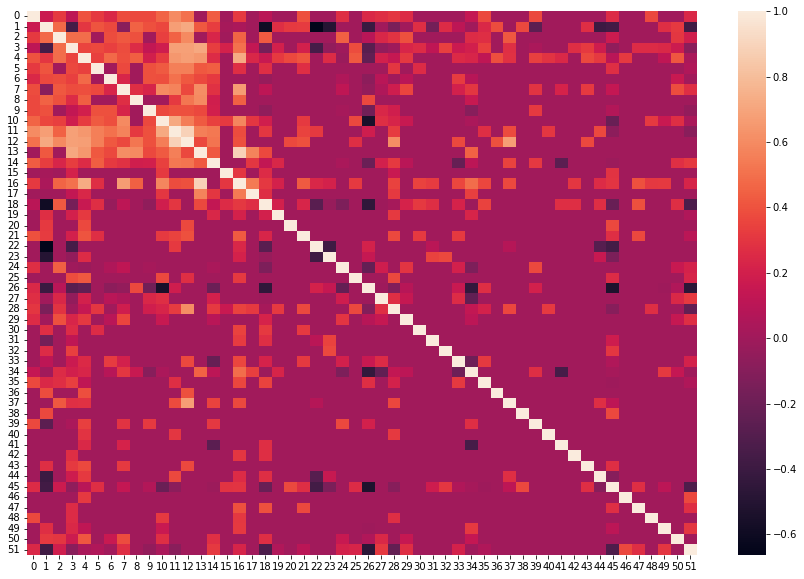

In [11]:
plt.figure(figsize=(15,10))
sns.heatmap(fit_data)
# plt.matshow(fit_data, cmap=plt.cm.Blues)

In [12]:
model.column_labels_

array([0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 1])

In [13]:
results = sim_matrix.mean().sort_values().to_frame().join(df.ID.value_counts()).join(pd.Series(index=sim_matrix.index, data=model.row_labels_, name='class'))
results.rename(columns={0:'mean simularity', 'ID':'number of values'}, inplace=True)
results

,mean simularity,number of values,class
ID,,,
A9HQ3E0F2AGVO,-0.043399,1217,1
AMYURTQIMAC8T,-0.032368,532,1
A2LU259QPV1I4V,0.077804,2689,1
AYTH0E5PUXWX8,0.096662,864,1
AD1ILDUXZHASF,0.113882,267,1
A1MG8KNVSVZ365,0.125757,3561,1
AR9AU5FY1S3RO,0.127690,990,1
A3BISMR4GI02ZG,0.129320,3589,0
AGRYG65WJ1CKJ,0.158242,201,1


It turned out that clustering grouped IDs with many interrelations in one bag and all other IDs in another. In that case IDs with a few samples got into the 'bot cluster'. But it's really not a big deal because making predictions for ID with less than 100 samples doesn't look reliable. So the final bot suspicion list would be next.

In [14]:
results[(results.loc[:, 'number of values']>=100) & (results.loc[:, 'class']==1)]

,mean simularity,number of values,class
ID,,,
A9HQ3E0F2AGVO,-0.043399,1217,1
AMYURTQIMAC8T,-0.032368,532,1
A2LU259QPV1I4V,0.077804,2689,1
AYTH0E5PUXWX8,0.096662,864,1
AD1ILDUXZHASF,0.113882,267,1
A1MG8KNVSVZ365,0.125757,3561,1
AR9AU5FY1S3RO,0.127690,990,1
AGRYG65WJ1CKJ,0.158242,201,1
A2CJFO19NY4T5R,0.185096,138,1
